# Predicting Survivability of Cancer Patients with Metastatic Patterns Using Explainable AI

Following training of the XGBoost Machine Learning model, and SHAP (SHapley Additive exPlanations) analysis, we selected the most important features and proceeded with survival analysis. The purpose to study the length of time until the occurrence of death of a patient following cancer diagnosis. In the analysis we will conduct the following:

1.	Perform Kaplan-Meier Survival Analysis
2.	Perform Cox Proportional Hazards Model
3.	Log-Rank Test for Comparing Groups

The selected features in the data include:

*	Overall Survival (Months)
*	Overall Survival Status
*	Metastatic patient
*	Met Site Count
*	TMB (nonsynonymous)
*	Fraction Genome Altered
*	Sample Type
*	Distant Mets: Liver"
*	Distant Mets: Bone
*	Distant Mets: Lung

## Goals:

To perform a Cox Proportional Hazards Model (Cox PH Model) and Log-Rank Test for survival analysis

## 1. Understanding the Goals
* Cox Proportional Hazards Model: Estimates the effect of multiple predictors (e.g., metastasis sites, TMB, genomic alterations) on survival time.
* Log-Rank Test: Compares survival distributions between two or more groups (e.g., Metastatic patient: Yes vs No or Sample Type: Primary vs Metastatic).

## 2. Prepare the Data
We ensure dataset is correctly formatted before fitting any survival models:

Survival time variable → `"Overall Survival (Months)"`
Censorship indicator → `"Overall Survival Status"` 

### Clean & Encode Data

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load data
df = pd.read_table("msk_met_2021.tsv")

# Convert survival status ('1:DECEASED' -> 1, '0:LIVING' -> 0)
df["Overall Survival Status"] = df["Overall Survival Status"].map({"1:DECEASED": 1, "0:LIVING": 0})

# Selecting key survival-related features (customize based on hypothesis)
key_columns = [
    "Overall Survival (Months)", "Overall Survival Status",
    "Metastatic patient", "Met Site Count", "TMB (nonsynonymous)", "Fraction Genome Altered",
    "Sample Type", "Distant Mets: Liver", "Distant Mets: Bone", "Distant Mets: Lung"
]

# Keep only non-null rows
data = df[key_columns].dropna()

# Convert categorical columns to numeric
data["Metastatic patient"] = data["Metastatic patient"].astype(int)
data["Sample Type"] = data["Sample Type"].astype("category").cat.codes  # Convert to numeric categories
for col in ["Distant Mets: Liver", "Distant Mets: Bone", "Distant Mets: Lung"]:
    data[col] = data[col].map({"Yes": 1, "No": 0})  # Convert presence of metastases to binary

print(data.info())  # Confirm the dataset is clean
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 25659 entries, 0 to 25774
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Overall Survival (Months)  25659 non-null  float64
 1   Overall Survival Status    25659 non-null  int64  
 2   Metastatic patient         25659 non-null  int64  
 3   Met Site Count             25659 non-null  int64  
 4   TMB (nonsynonymous)        25659 non-null  float64
 5   Fraction Genome Altered    25659 non-null  float64
 6   Sample Type                25659 non-null  int8   
 7   Distant Mets: Liver        25659 non-null  int64  
 8   Distant Mets: Bone         25659 non-null  int64  
 9   Distant Mets: Lung         25659 non-null  int64  
dtypes: float64(3), int64(6), int8(1)
memory usage: 2.0 MB
None


,Overall Survival (Months),Overall Survival Status,Metastatic patient,Met Site Count,TMB (nonsynonymous),Fraction Genome Altered,Sample Type,Distant Mets: Liver,Distant Mets: Bone,Distant Mets: Lung
0,3.78,1,1,2,4.436621,0.2782,1,1,1,0
1,13.90,1,1,8,7.764087,0.3503,0,1,1,1
2,35.06,1,1,5,6.654932,0.3878,0,1,1,1
3,46.00,1,1,8,1.957439,0.1020,0,1,0,0
4,80.59,0,1,7,4.436621,0.4196,0,1,0,1


## 3. Cox Proportional Hazards Model
This model estimates the hazard ratio (HR) for each predictor while controlling for other variables.

#### Fit Cox PH Model

In [2]:
cph = CoxPHFitter()
cph.fit(data, duration_col="Overall Survival (Months)", event_col="Overall Survival Status")
cph.print_summary()  # Display coefficients and p-values


<lifelines.CoxPHFitter: fitted with 25659 total observations, 15491 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival Status'
      baseline estimation = breslow
   number of observations = 25659
number of events observed = 10168
   partial log-likelihood = -94923.87
         time fit was run = 2025-02-07 17:44:00 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
Metastatic patient       0.78      2.18      0.05            0.68            0.88                1.97                2.42
Met Site Count           0.03      1.03      0.01            0.02            0.04                1.02                1.04
TMB (nonsynonymous)     -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
Fraction Genome Altered  0.28      1.32      0.05            0.18            0.38                1.19                1.46
Sample Type             -0.14      0.87      0.02           -0.18           -0.10                0.83                0.90
Distant Mets: Liver      0.59      1.81      0.02            0.55            0.64                1.73                1.90
Distant Mets: Bone       0.36      1.43      0.02            0.31            0.40                1.37                1.50
Distant Mets: Lung       0.15      1.16      0.02            0.11            0.20                1.11                1.22

                         cmp to     z      p  -log2(p)
covariate                                             
Metastatic patient         0.00 14.79 <0.005    161.95
Met Site Count             0.00  6.42 <0.005     32.73
TMB (nonsynonymous)        0.00 -4.37 <0.005     16.31
Fraction Genome Altered    0.00  5.43 <0.005     24.07
Sample Type                0.00 -6.76 <0.005     36.03
Distant Mets: Liver        0.00 25.35 <0.005    468.47
Distant Mets: Bone         0.00 15.76 <0.005    183.45
Distant Mets: Lung         0.00  6.68 <0.005     35.28
---
Concordance = 0.66
Partial AIC = 189863.73
log-likelihood ratio test = 3811.90 on 8 df
-log2(p) of ll-ratio test = inf

### Interpretation of Results
* Hazard Ratios `exp(coef)`): HR > 1 means increased risk of death; HR < 1 means protective effect.
* `p-values`: Significant predictors (p < 0.05) contribute meaningfully to survival risk.

### 4. Log-Rank Test
The Log-Rank Test compares survival curves between groups.

#### Compare Metastatic patient Groups

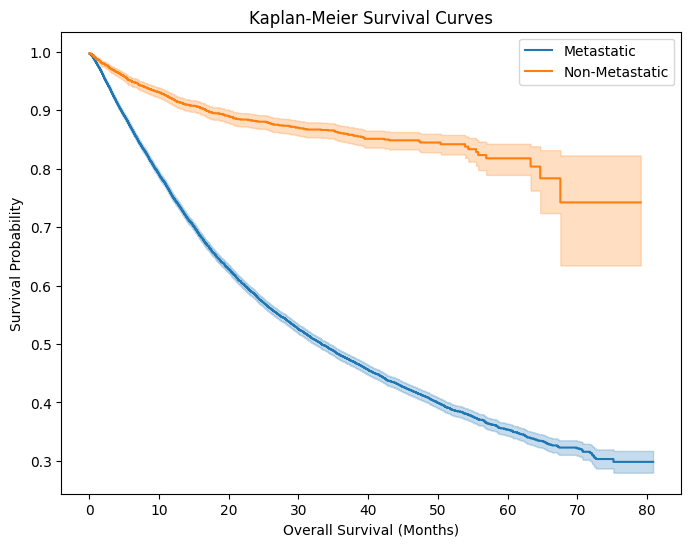

Log-Rank Test p-value: 2.1020128198913278e-236


In [3]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Split into two groups
group1 = data[data["Metastatic patient"] == 1]  # Metastatic
group2 = data[data["Metastatic patient"] == 0]  # Non-metastatic

# Fit and plot survival curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
kmf1.fit(group1["Overall Survival (Months)"], event_observed=group1["Overall Survival Status"], label="Metastatic")
kmf2.fit(group2["Overall Survival (Months)"], event_observed=group2["Overall Survival Status"], label="Non-Metastatic")

kmf1.plot_survival_function()
kmf2.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Overall Survival (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

# Perform Log-Rank Test
results = logrank_test(group1["Overall Survival (Months)"], group2["Overall Survival (Months)"], 
                       event_observed_A=group1["Overall Survival Status"], 
                       event_observed_B=group2["Overall Survival Status"])
print("Log-Rank Test p-value:", results.p_value)
